In [1]:
import matplotlib.pyplot as plt
from matplotlib import cm
from matplotlib.ticker import LinearLocator
import numpy as np
import xarray as xr
import netCDF4 as nc
import math

di = '/home/claire/Github-forked/MOM6-examples/ocean_only/seamount/isomip'

NHALO = 4
IC_FILE = 'MOM_IC.nc'
SHELF_IC_FILE = 'MOM_Shelf_IC.nc'
PROG_FILE = 'prog.nc'
ICE_SHELF_FILE = '/INPUT/shelfX.nc'
TOPO_FILE = '/INPUT/topogX.nc'
THICKNESS_FILE = '/INPUT/thickness.nc'

In [3]:
### Make symmetric version of '/INPUT/Ocean1_3D.nc'
### symmetrized version to be stored in 'filename'
def symmetrize_ocean1(filename):
    
    isf = xr.open_dataset(di + "/INPUT/Ocean1_3D.nc")
    l_thick = isf.thick[:20,:]
    r_thick = np.flip(l_thick, axis=0)
    l_area = isf.area[:20,:]
    r_area = np.flip(l_area, axis=0)

    new_shelf = nc.Dataset(filename, "w", format="NETCDF4")
    new_shelf.createDimension("ny", 40)
    new_shelf.createDimension("nx", 240)
    new_shelf.createVariable("thick","f8",("ny","nx"))
    new_shelf.createVariable("area","f8",("ny","nx"))

    new_shelf["area"][:20,:] = l_area.data
    new_shelf["thick"][:20,:] = l_thick.data
    new_shelf["area"][20:,:] = r_area.data
    new_shelf["thick"][20:,:] = r_thick.data

    new_shelf.close()    

In [4]:
### new thickness file for THICKNESS_CONFIG="thickness_file"
### (depends on MOM6 output in IC_FILE, ie. use after a run)
def make_thickness_file(filename):
    
    ic = xr.open_dataset(di + '/' + IC_FILE)
    _, nz, ny, nx = ic.h.data.shape

    new_thick = nc.Dataset(filename, "w", format="NETCDF4")
    new_thick.createDimension("nz", nz)
    new_thick.createDimension("ny", ny)
    new_thick.createDimension("nx", nx)
    new_thick.createVariable("h","f8",("nz","ny","nx"))

    new_thick["h"][:,:,:] = ic.h.data
    new_thick.close()

In [5]:
### 3D depiction of topography and ice shelf
### depends on MOM6 output in IC_FILE and SHELF_IC_FILE
def display_config():
    
    ic = xr.open_dataset(di + "/"+ IC_FILE)
    ms = xr.open_dataset(di + "/" + SHELF_IC_FILE)
    #ms = xr.open_dataset(di + "/" + ICE_SHELF_FILE)
    #tp = xr.open_dataset(di + "/" + TOPO_FILE)

    LY, LX = ic.h.data[0].shape[1], ic.h.data[0].shape[2]
    YY= np.arange(0, LY, 1)
    XX = np.arange(0, LX, 1)
    XX, YY = np.meshgrid(XX, YY)

    fig, axes = plt.subplots(nrows = 1, ncols=2, figsize = (10,4), subplot_kw={"projection": "3d"})

    surf = axes[0].plot_surface(XX, YY, ms.h_shelf.data[0])
    #surf = axes[0].plot_surface(XX, YY, ms.thick.data)
    axes[0].set_title("Input ICE SHELF h")

    eta = ic.eta[0].data[0]
    bathyT = eta - np.sum(ic.h[0].data, axis=0)

    axes[1].plot_surface(XX, YY, eta)
    axes[1].plot_surface(XX, YY, bathyT)
    #topo2 = axes[1].plot_surface(XX, YY, -tp.depth.data)

    axes[1].set_title("Initial TOPOGRAPHY and ICE SHELF")

    ms.close()
    ic.close()

In [6]:
symmetrize_ocean1(di + ICE_SHELF_FILE)

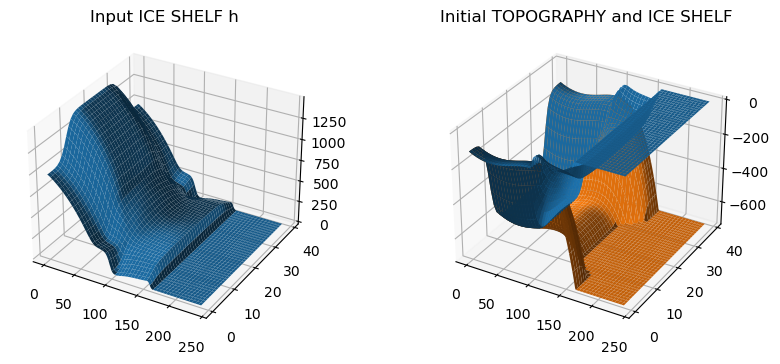

In [37]:
display_config()

In [134]:
make_thickness_file(di + THICKNESS_FILE)

### Plot output h,e,salt etc at chosen time

Text(0.5, 0.98, 'Run ends at 0001-01-01 01:00:00')

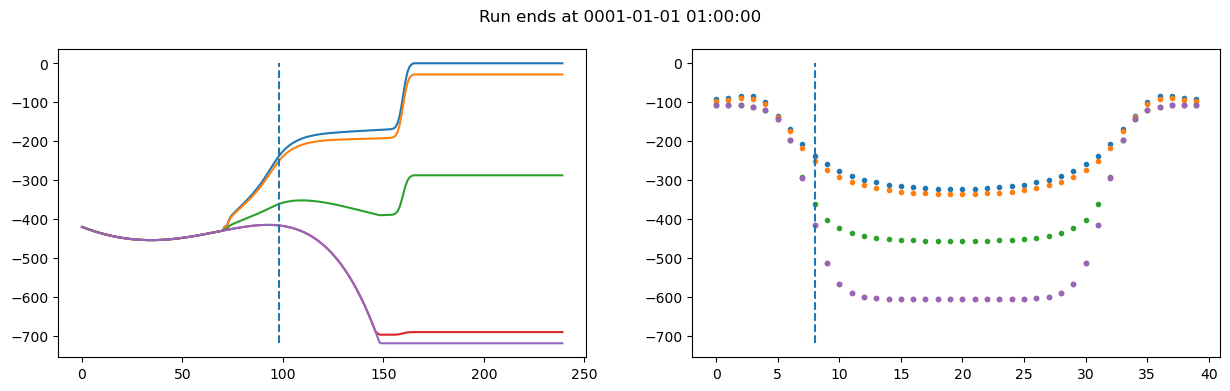

In [209]:
prog = xr.open_dataset(di + '/'+PROG_FILE)
last_time = prog.coords["Time"].values[-1]
     
fig,axes = plt.subplots(nrows = 1, ncols = 2, figsize = (15,4))
tt=-1; zz= 10; yy=8; xx=98; ll = [0,1,zz,-2,-1] # ll=[0,1,2,3,4,5,10,-3,-2,-1]
for zzz in ll:
    axes[0].plot(prog.e[tt][zzz].data[yy,:])
    axes[1].plot(prog.e[tt][zzz].data[:,xx],'.')
axes[0].vlines(xx, -720, 0, linestyles='dashed')
axes[1].vlines(yy, -720, 0, linestyles='dashed')
fig.suptitle("Run ends at {}".format(last_time))

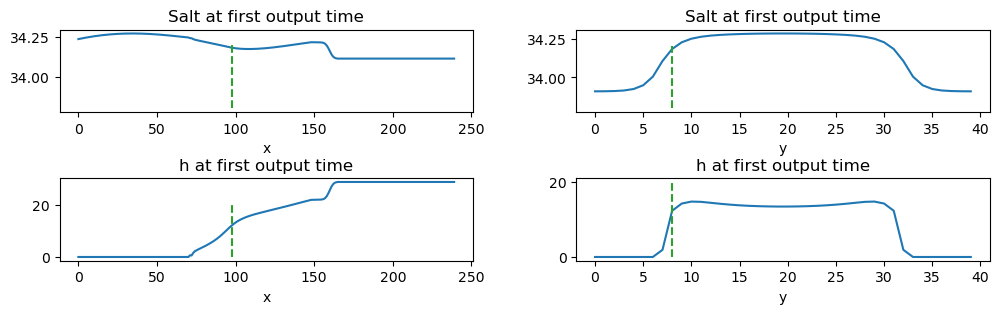

In [208]:
### Can see that the initial salt is "bad" with THICKNESS_CONFIG="ISOMIP" but "fixed" with THICKNESS_CONFIG="thickness_file" hack
ttt = 0; zzz = 10; yyy=8; xxx=98
fig,axes = plt.subplots(nrows = 2, ncols = 2, figsize = (12,3))
axes[0,0].plot(prog.salt.data[ttt][zzz][yyy,:])
axes[0,0].vlines(xxx, 33.8, 34.2, linestyles='dashed', colors='C2')
axes[0,0].set_xlabel("x")
axes[0,0].set_title("Salt at first output time")
axes[0,1].plot(prog.salt.data[ttt][zzz][:,xxx])
axes[0,1].vlines(yyy, 33.8, 34.2, linestyles='dashed', colors='C2')
axes[0,1].set_xlabel("y")
axes[0,1].set_title("Salt at first output time")
axes[1,0].plot(prog.h.data[ttt][zzz][yyy,:])
axes[1,0].set_xlabel("x")
axes[1,0].vlines(xxx, 0, 20, linestyles='dashed', colors='C2')
axes[1,0].set_title("h at first output time")
axes[1,1].plot(prog.h.data[ttt][zzz][:,xxx])
axes[1,1].vlines(yyy, 0, 20, linestyles='dashed', colors='C2')
axes[1,1].set_xlabel("y")
axes[1,1].set_title("h at first output time")

plt.subplots_adjust(wspace = 0.25, hspace = 0.8)

In [204]:
np.nanmin(prog.h[0].data)

9.999999999795073e-10

In [205]:
print(np.nanmax(prog.u.data[-1]), np.nanmin(prog.u.data[-1])) # 0.0012509557073082142 -0.0006301157530793094

0.001188688797034256 -0.004808195107867875


In [206]:
print(np.nanmax(prog.v.data[-1]), np.nanmin(prog.v.data[-1])) # 0.0012509557073082142 -0.0006301157530793094

0.008820643018310065 -0.008820643018310065


In [207]:
arr = prog.v.data[-1]
ind = np.unravel_index(np.nanargmax(arr),arr.shape)
print(arr[ind])
ind

0.008820643018310065


(10, 8, 98)

np.nanmin(prog.e.data[0])

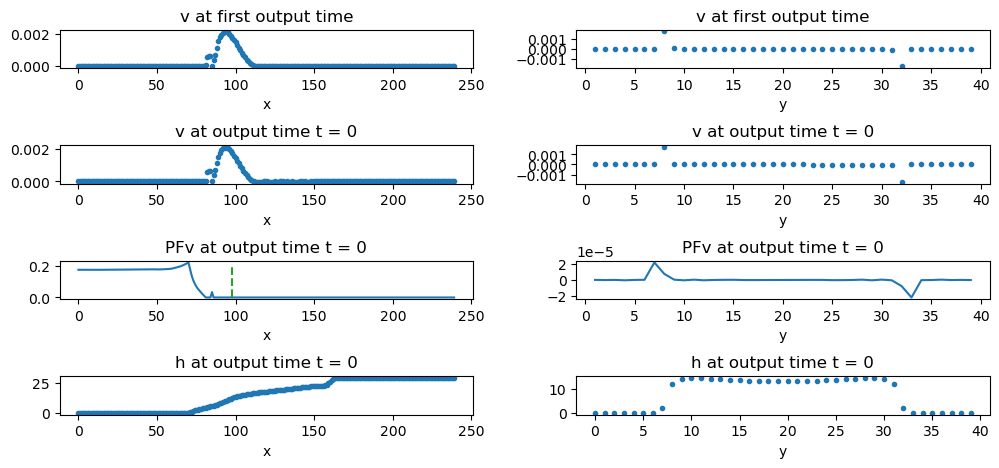

In [211]:
mo = xr.open_dataset(di + '/mom.nc')
fig,axes = plt.subplots(nrows = 4, ncols = 2, figsize = (12,5))

tt=0; zz=10; yy=8; xx=98
showU = False
if (showU):
    u_or_v = "u"; PFu_or_v = "PFu"; prog_field = prog.u; mo_field = mo.PFu
else:
    u_or_v = "v"; PFu_or_v = "PFv"; prog_field = prog.v; mo_field = mo.PFv
    
axes[0,0].plot(prog_field[0][zz].data[yy,:],'.')
axes[0,0].set_xlabel("x")
axes[0,0].set_title("{} at first output time".format(u_or_v)) # depends on diag_table setting
axes[0,1].plot(prog_field[0][zz].data[:,xx],'.')
axes[0,1].set_xlabel("y")
axes[0,1].set_title("{} at first output time".format(u_or_v)) # depends on diag_table setting
axes[1,0].plot(prog_field[tt][zz].data[yy,:],'.',)
axes[1,0].set_xlabel("x")
axes[1,0].set_title("{} at output time t = {}".format(u_or_v, tt))
axes[1,1].plot(prog_field[tt][zz].data[:,xx],'.')
axes[1,1].set_xlabel("y")
axes[1,1].set_title("{} at output time t = {}".format(u_or_v,tt))
axes[2,0].plot(mo_field[tt][zz].data[yy,:])
axes[2,0].vlines(xx, 0, 0.2, linestyles='dashed', colors='C2')
axes[2,0].set_xlabel("x")
axes[2,0].set_title("{} at output time t = {}".format(PFu_or_v,tt))
axes[2,1].plot(mo_field[tt][zz].data[:,xx])
axes[2,1].set_xlabel("y")
axes[2,1].set_title("{} at output time t = {}".format(PFu_or_v, tt))
axes[3,0].plot(prog.h[tt][zz].data[yy,:],'.')
axes[3,0].set_xlabel("x")
axes[3,0].set_title("h at output time t = {}".format(tt))
axes[3,1].plot(prog.h[tt][zz].data[:,xx],'.',)
axes[3,1].set_xlabel("y")
axes[3,1].set_title("h at output time t = {}".format(tt))

plt.subplots_adjust(wspace = 0.25, hspace = 2.0)

mo.close()

Text(0.5, 1.0, 'forcing at output time t = -1')

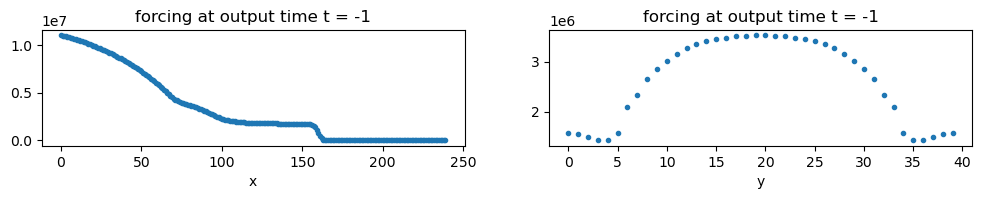

In [184]:
fc = xr.open_dataset(di + '/forcing.nc')

fig,axes = plt.subplots(nrows = 1, ncols = 2, figsize = (12,1.5))

tt=-1; yy=8; xx=95

#fc_field = fc.taux
#fc_field = fc.tauy
#fc_field = fc.ustar
#fc_field = fc.PRCmE
fc_field = fc.p_surf

#axes[0,0].plot(aft.u.data[zzz,yy+NHALO,NHALO:-NHALO])
axes[0].plot(fc_field[tt].data[yy,:],'.')
axes[0].set_xlabel("x")
axes[0].set_title("forcing at output time t = {}".format(tt)) # depends on diag_table setting
axes[1].plot(fc_field[tt].data[:,xx],'.')
axes[1].set_xlabel("y")
axes[1].set_title("forcing at output time t = {}".format(tt)) # depends on diag_table setting

In [25]:
! cat input.nml | tail

 
 &ocean_solo_nml
            months = 0
            date_init = 1,1,1,0,0,0
            days = 0
            hours = 5
            minutes = 0
            seconds = 0
            calendar = 'julian' /



In [212]:
! cat diag_table | head

"GOLD Experiment"
1 1 1 0 0 0
"prog",     300,"seconds",1,"days","Time"
"mom",     300,"seconds",1,"days","Time"
"forcing",     300,"seconds",1,"days","Time"
"ice",     300,"seconds",1,"days","Time"
#"prog",     1,"hours",1,"days","Time"
#"mom",     1,"hours",1,"days","Time"
#"forcing",     1,"hours",1,"days","Time"
#"ice",     1,"hours",1,"days","Time"


In [27]:
! cat MOM_override | tail


!!!!!!!!!!!!!!!!!  Thickness from  file??   !!!!!!!!

!#override ADJUST_SALT = True

!#override THICKNESS_CONFIG = "ISOMIP"     ! default = "uniform"
#override THICKNESS_CONFIG = "thickness_file"     ! default = "uniform"
#override THICKNESS_FILE = "thickness.nc"     ! default = "uniform"
#override REMAP_AFTER_INITIALIZATION = False
#override HACK_MODE = True


In [94]:
ice=xr.open_dataset(di + '/' + "ice.nc")
ice

<xarray.Dataset>
Dimensions:          (xT: 240, yT: 40, Time: 5, xB: 241, yB: 41)
Coordinates:
  * xT               (xT) float64 321.0 323.0 325.0 327.0 ... 795.0 797.0 799.0
  * yT               (yT) float64 1.0 3.0 5.0 7.0 9.0 ... 73.0 75.0 77.0 79.0
  * Time             (Time) object 0001-01-01 01:00:00 ... 0001-01-01 05:00:00
  * xB               (xB) float64 320.0 322.0 324.0 326.0 ... 796.0 798.0 800.0
  * yB               (yB) float64 0.0 2.0 4.0 6.0 8.0 ... 74.0 76.0 78.0 80.0
Data variables: (12/15)
    area_shelf_h     (Time, yT, xT) float32 ...
    shelf_mass       (Time, yT, xT) float32 ...
    h_shelf          (Time, yT, xT) float32 ...
    mass_flux        (Time, yT, xT) float32 ...
    melt_rate        (Time, yT, xT) float32 ...
    thermal_driving  (Time, yT, xT) float32 ...
    ...               ...
    v_ml             (Time, yB, xT) float32 ...
    exch_vel_s       (Time, yT, xT) float32 ...
    exch_vel_t       (Time, yT, xT) float32 ...
    tfreeze          (Time, yT, xT) float32 ...
    tflux_shelf      (Time, yT, xT) float32 ...
    ustar_shelf      (Time, yT, xT) float32 ...
Attributes:
    filename:   ice.nc
    title:      GOLD Experiment
    grid_type:  regular
    grid_tile:  N/A

In [189]:
np.unique(np.concatenate((np.unique(ice.mass_flux[-1].data),
                          np.unique(ice.melt_rate[-1].data),
                         #np.unique(ice.thermal_driving[-1].data),
                         np.unique(ice.haline_driving[-1].data),
                         #np.unique(ice.sbdry[-1].data),
                         #np.unique(ice.u_ml[-1].data),
                         #np.unique(ice.v_ml[-1].data),
                         np.unique(ice.exch_vel_s[-1].data),
                         np.unique(ice.exch_vel_t[-1].data),
                         np.unique(ice.tfreeze[-1].data),
                         np.unique(ice.tflux_shelf[-1].data),
                         #np.unique(ice.ustar_shelf[-1].data)
                         )))

array([0.], dtype=float32)